### 1. Instalacion de Dependencias

In [2]:
%pip install kagglehub pandas sqlite-utils


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 2. Importacion de Dependencias

In [3]:
import sys, subprocess, os, glob
from pathlib import Path
import kagglehub
import pandas as pd
import os, re, sqlite3, pandas as pd

from __future__ import annotations

import argparse
import unicodedata
from pathlib import Path
from typing import List, Dict

import numpy as np

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3. Creacion de directorios

In [4]:
data_path = Path("data")
data_path.mkdir(exist_ok=True)
print("📁 Carpeta 'data' lista en:", data_path.resolve())
raw_data_path = Path("data/raw_data")
raw_data_path.mkdir(exist_ok=True)
print("📁 Carpeta de datos sin procesar lista en:", data_path.resolve())
normal_data_path = Path("data/normalized_data")
normal_data_path.mkdir(exist_ok=True)
print("📁 Carpeta de datos procesados lista en:", data_path.resolve())

📁 Carpeta 'data' lista en: /workspaces/integrated5/data
📁 Carpeta de datos sin procesar lista en: /workspaces/integrated5/data
📁 Carpeta de datos procesados lista en: /workspaces/integrated5/data


### 4. Descarga de DataSets

In [5]:
datasets = [
    'fredericksalazar/global-imports-goods-and-services-1960-present',
    'fredericksalazar/global-exports-of-goods-and-services-1960-present',
    'fredericksalazar/pib-gdp-global-by-countries-since-1960-to-2021',
    'fredericksalazar/global-inflation-rate-1960-present',
    #'kaggle/world-development-indicators'
]

for ds in datasets:
    print(f"\n⬇️ Descargando: {ds}")
    try:
        path = kagglehub.dataset_download(ds)
        print("✅ Descargado en:", path)
        # Mover a la carpeta db (opcional, según preferencia)
        os.system(f"cp -r '{path}'/* '{raw_data_path}/' 2>/dev/null || xcopy '{path}' '{raw_data_path}' /E /I /Y")
    except Exception as e:
        print("❌ Error descargando", ds, "->", e)



⬇️ Descargando: fredericksalazar/global-imports-goods-and-services-1960-present
✅ Descargado en: /home/codespace/.cache/kagglehub/datasets/fredericksalazar/global-imports-goods-and-services-1960-present/versions/1

⬇️ Descargando: fredericksalazar/global-exports-of-goods-and-services-1960-present
✅ Descargado en: /home/codespace/.cache/kagglehub/datasets/fredericksalazar/global-exports-of-goods-and-services-1960-present/versions/1

⬇️ Descargando: fredericksalazar/pib-gdp-global-by-countries-since-1960-to-2021
✅ Descargado en: /home/codespace/.cache/kagglehub/datasets/fredericksalazar/pib-gdp-global-by-countries-since-1960-to-2021/versions/4

⬇️ Descargando: fredericksalazar/global-inflation-rate-1960-present
✅ Descargado en: /home/codespace/.cache/kagglehub/datasets/fredericksalazar/global-inflation-rate-1960-present/versions/1


### 5. Normalizando DataSets
* Se procedio con ajustar los datasets de separacion errada de ; a ,
* Los campos en blanco ('', ' ', 'NA', 'NaN', 'nan') fueron rellenados

In [6]:
import os
import pandas as pd
import numpy as np

# Recomendación de pandas para el warning de downcasting:
pd.set_option('future.no_silent_downcasting', True)

THRESHOLD_EMPTY_ROW = 0.5

def detect_sep(path, default=','):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        head = f.readline()
    if ';' in head and ',' not in head:
        return ';'
    return default

for file in os.listdir(raw_data_path):
    if not file.lower().endswith(".csv"):
        continue

    path = os.path.join(raw_data_path, file)
    sep = detect_sep(path)
    print(f"📄 Procesando {file} (separador detectado: '{sep}')")

    # 1) Cargar como texto para limpiar sin conflictos de tipo
    try:
        df = pd.read_csv(path, sep=sep, dtype=str, encoding='utf-8',
                         na_values=['', ' ', 'NA', 'NaN', 'nan'])
    except Exception as e:
        print(f"⚠️ Error leyendo {file}: {e}")
        continue

    # 2) Vacíos → NA (y aplicar la recomendación de pandas para evitar el FutureWarning)
    df = df.replace(r'^\s*$', pd.NA, regex=True)
    df = df.infer_objects(copy=False)

    # 3) Métrica de vacíos
    empty_total = df.isna().sum().sum()
    print(f"🔍 Campos vacíos detectados: {empty_total}")

    # 4) Eliminar filas con >50% vacíos
    df_clean = df[df.isna().mean(axis=1) < THRESHOLD_EMPTY_ROW].copy()

    # 5) Tipos: intenta convertir a numérico si ≥60% se pueden convertir
    for col in df_clean.columns:
        as_num = pd.to_numeric(df_clean[col], errors='coerce')
        if as_num.notna().mean() >= 0.6:
            df_clean[col] = as_num

    # 6) Rellenar SOLO texto con "N/A" (numéricas quedan con NaN)
    obj_cols = df_clean.select_dtypes(include=['object']).columns
    if len(obj_cols):
        df_clean.loc[:, obj_cols] = df_clean.loc[:, obj_cols].fillna("N/A")

    # 7) Asegurar extensión .csv SIEMPRE
    base_name = os.path.splitext(file)[0] + ".csv"
    out_path = os.path.join(normal_data_path, base_name)

    # 8) Guardar con comas
    df_clean.to_csv(out_path, index=False, sep=',', encoding='utf-8', lineterminator='\n')
    print(f"✅ Guardado normalizado: {out_path}\n")


📄 Procesando imports_goods_services_organizations.csv (separador detectado: ',')


🔍 Campos vacíos detectados: 3328
✅ Guardado normalizado: data/normalized_data/imports_goods_services_organizations.csv

📄 Procesando countries_gdp_hist.csv (separador detectado: ';')
🔍 Campos vacíos detectados: 0
✅ Guardado normalizado: data/normalized_data/countries_gdp_hist.csv

📄 Procesando organizations_gdp_hist.csv (separador detectado: ';')
🔍 Campos vacíos detectados: 128
✅ Guardado normalizado: data/normalized_data/organizations_gdp_hist.csv

📄 Procesando import_goods_services_countries_dataset.csv (separador detectado: ',')
🔍 Campos vacíos detectados: 13440
✅ Guardado normalizado: data/normalized_data/import_goods_services_countries_dataset.csv

📄 Procesando global_inflation_organizations.csv (separador detectado: ',')
🔍 Campos vacíos detectados: 3328
✅ Guardado normalizado: data/normalized_data/global_inflation_organizations.csv

📄 Procesando global_inflation_countries.csv (separador detectado: ',')
🔍 Campos vacíos detectados: 13440
✅ Guardado normalizado: data/normalized_data

### 6. Visualizacion de datasets normalizados

In [7]:
try:
    import pandas as pd
    csvs = glob.glob("data/normalized_data/*.csv", recursive=True)
    print(f"\nSe encontraron {len(csvs)} archivos CSV.")
    for csv in csvs[:14]:
        print("\n🔍 Vista previa →", csv)
        display(pd.read_csv(csv, nrows=10))
except Exception as e:
    print("\n(No se pudo mostrar vista previa de CSVs):", e)



Se encontraron 8 archivos CSV.

🔍 Vista previa → data/normalized_data/imports_goods_services_organizations.csv


,country_name,country_code,region,income_group,indicator_name,indicator_code,year,imports_of_goods_and_services
0,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1960,12.320025
1,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1961,12.222391
2,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1962,11.366719
3,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1963,11.991174
4,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1964,11.230352
5,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1965,10.715068
6,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1966,11.063500
7,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1967,11.194919
8,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1968,11.205275
9,INGRESO MEDIANO,MIC,NaN,AGREGADOS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.IMP.GNFS.ZS,1969,10.845661



🔍 Vista previa → data/normalized_data/countries_gdp_hist.csv


,country_code,region_name,sub_region_name,intermediate_region,country_name,income_group,year,total_gdp,total_gdp_million,gdp_variation
0,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1960,0.0,0.0,0.0
1,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1961,0.0,0.0,0.0
2,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1962,0.0,0.0,0.0
3,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1963,0.0,0.0,0.0
4,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1964,0.0,0.0,0.0
5,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1965,0.0,0.0,0.0
6,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1966,0.0,0.0,0.0
7,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1967,0.0,0.0,0.0
8,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1968,0.0,0.0,0.0
9,ABW,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,ARUBA,INGRESO ALTO,1969,0.0,0.0,0.0



🔍 Vista previa → data/normalized_data/organizations_gdp_hist.csv


,country_code,organization_name,region,income_group,year,total_gdp,total_gdp_million,gdp_variation
0,AFE,NaN,NO DATA,AGREGADOS,1960,2.421063e+10,24210.632546,0.000000
1,AFE,NaN,NO DATA,AGREGADOS,1961,2.496398e+10,24963.977551,0.468736
2,AFE,NaN,NO DATA,AGREGADOS,1962,2.707880e+10,27078.797299,7.869709
3,AFE,NaN,NO DATA,AGREGADOS,1963,3.177575e+10,31775.749181,5.622374
4,AFE,NaN,NO DATA,AGREGADOS,1964,3.028579e+10,30285.794057,4.690458
5,AFE,NaN,NO DATA,AGREGADOS,1965,3.381317e+10,33813.171214,5.159574
6,AFE,NaN,NO DATA,AGREGADOS,1966,3.693497e+10,36934.974917,4.822754
7,AFE,NaN,NO DATA,AGREGADOS,1967,3.845217e+10,38452.170916,5.373502
8,AFE,NaN,NO DATA,AGREGADOS,1968,4.175072e+10,41750.716743,4.153710
9,AFE,NaN,NO DATA,AGREGADOS,1969,4.705830e+10,47058.301051,5.090731



🔍 Vista previa → data/normalized_data/import_goods_services_countries_dataset.csv


,country_code,country_name,region,sub_region,intermediate_region,indicator_code,indicator_name,year,imports_of_goods_and_services
0,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1960,0.0
1,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1961,0.0
2,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1962,0.0
3,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1963,0.0
4,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1964,0.0
5,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1965,0.0
6,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1966,0.0
7,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1967,0.0
8,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1968,0.0
9,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1969,0.0



🔍 Vista previa → data/normalized_data/global_inflation_organizations.csv


,country_name,country_code,region,income_group,indicator_name,indicator_code,year,inflation_rate
0,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1960,0.0
1,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1961,0.0
2,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1962,0.0
3,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1963,0.0
4,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1964,0.0
5,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1965,0.0
6,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1966,0.0
7,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1967,0.0
8,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1968,0.0
9,INGRESO MEDIANO,MIC,NaN,AGREGADOS,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",FP.CPI.TOTL.ZG,1969,0.0



🔍 Vista previa → data/normalized_data/global_inflation_countries.csv


,country_code,country_name,region,sub_region,intermediate_region,indicator_code,indicator_name,year,inflation_rate
0,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1960,0.0
1,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1961,0.0
2,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1962,0.0
3,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1963,0.0
4,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1964,0.0
5,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1965,0.0
6,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1966,0.0
7,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1967,0.0
8,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1968,0.0
9,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,FP.CPI.TOTL.ZG,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",1969,0.0



🔍 Vista previa → data/normalized_data/export_goods_services_countries_dataset.csv


,country_code,country_name,region,sub_region,intermediate_region,indicator_code,indicator_name,year,exports_of_goods_and_services
0,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1960,0.0
1,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1961,0.0
2,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1962,0.0
3,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1963,0.0
4,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1964,0.0
5,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1965,0.0
6,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1966,0.0
7,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1967,0.0
8,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1968,0.0
9,AFG,AFGANISTAN,ASIA MERIDIONAL,SOUTHERN ASIA,NaN,NE.EXP.GNFS.ZS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),1969,0.0



🔍 Vista previa → data/normalized_data/export_goods_services_organizations.csv


,country_name,country_code,region,income_group,indicator_name,indicator_code,year,exports_of_goods_and_services
0,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1960,10.091362
1,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1961,10.316034
2,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1962,9.810639
3,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1963,10.824773
4,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1964,10.017210
5,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1965,9.776433
6,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1966,9.998912
7,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1967,10.001343
8,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1968,10.142621
9,INGRESO MEDIANO,MIC,NaN,AGREGADOS,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),NE.EXP.GNFS.ZS,1969,9.949430


### 7. Normalizar columnas y mapear sinónimos
Al procesar los dataset para estandarizar los datos, se pudo observar que los datasets tomados eran heterogeneos por lo que requirieron unificar terminos y ajustar campos que no estuvieran normalizados

In [8]:
import os
import re
import unicodedata
import pandas as pd
import numpy as np

BASE_DIR = "data/normalized_data"
OUT_DIR  = "data/unified_data"
os.makedirs(OUT_DIR, exist_ok=True)

# --- 1) Normalizador de nombres de columnas a snake_case ---
def to_snake(s: str) -> str:
    if s is None: return s
    # quitar acentos
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    s = s.strip().lower()
    s = re.sub(r'[^\w]+', '_', s)
    s = re.sub(r'_+', '_', s).strip('_')
    if not s: s = "col"
    # evitar empezar por dígito
    if re.match(r'^\d', s):
        s = f"f_{s}"
    return s

# --- 2) Renombrado "semántico" de sinónimos → esquema canónico ---
CANONICAL_MAP = {
    # geo
    "country": "country_name",
    "countryname": "country_name",
    "country_name": "country_name",
    "country_code": "country_code",
    "region": "region",
    "region_name": "region",
    "sub_region": "sub_region",
    "sub_region_name": "sub_region",
    "intermediate_region": "intermediate_region",
    "organization_name": "organization_name",
    "income_group": "income_group",

    # indicador (nombre/código)
    "indicator": "indicator_name",
    "indicator_name": "indicator_name",
    "indicator_code": "indicator_code",

    # tiempo
    "year": "year",

    # valores comunes
    "imports_of_goods_and_services": "imports_percent_gdp",
    "exports_of_goods_and_services": "exports_percent_gdp",
    "inflation_rate": "inflation_percent",
    "total_gdp": "gdp_current_local",         # si viene en moneda local
    "total_gdp_million": "gdp_current_million",
    "gdp_variation": "gdp_growth_percent",    # columna de % crecimiento si así la definiste
}

# --- 3) Mapeo de columnas → indicator_code (si no viene en el archivo) ---
VALUE_TO_INDICATOR = {
    "imports_percent_gdp": "NE.IMP.GNFS.ZS",
    "exports_percent_gdp": "NE.EXP.GNFS.ZS",
    "inflation_percent":   "FP.CPI.TOTL.ZG",
    "gdp_growth_percent":  "NY.GDP.MKTP.KD.ZG",   # crecimiento real (%), si tu columna representa eso
    "gdp_current_million": "NY.GDP.MKTP.CD_MLN",  # etiqueta interna: PIB actual (millones de moneda base del CSV)
    "gdp_current_local":   "NY.GDP.MKTP.CD_LOCAL" # etiqueta interna: PIB actual (moneda local si aplica)
}

# --- 4) Catálogo de nombres "bonitos" por indicator_code ---
INDICATOR_NAME_BY_CODE = {
    "NE.IMP.GNFS.ZS":      "Imports of goods and services (% of GDP)",
    "NE.EXP.GNFS.ZS":      "Exports of goods and services (% of GDP)",
    "FP.CPI.TOTL.ZG":      "Inflation, consumer prices (annual %)",
    "NY.GDP.MKTP.KD.ZG":   "GDP growth (annual %)",
    "NY.GDP.MKTP.CD_MLN":  "GDP, current (million units in file)",
    "NY.GDP.MKTP.CD_LOCAL":"GDP, current (local units in file)"
}

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    # 1) a snake_case
    df = df.copy()
    df.columns = [to_snake(c) for c in df.columns]
    # 2) renombrar sinónimos a canónico (solo si conocemos el nombre)
    new_cols = {}
    for c in df.columns:
        new_cols[c] = CANONICAL_MAP.get(c, c)
    df = df.rename(columns=new_cols)
    return df


### 8. Cargar todos los CSV, normalizar y construir hechos
Con el fin de tener la informacion lo mas uniforme posible se crea unos consolidados de hechos los cuales nos serviran como la base uniforme de los datos

In [9]:
from typing import List, Dict

files = [f for f in os.listdir(BASE_DIR) if f.lower().endswith(".csv")]
print("Archivos detectados:", len(files))
files[:8]


Archivos detectados: 8


['imports_goods_services_organizations.csv',
 'countries_gdp_hist.csv',
 'organizations_gdp_hist.csv',
 'import_goods_services_countries_dataset.csv',
 'global_inflation_organizations.csv',
 'global_inflation_countries.csv',
 'export_goods_services_countries_dataset.csv',
 'export_goods_services_organizations.csv']

In [10]:
all_facts: List[pd.DataFrame] = []
geo_frames: List[pd.DataFrame] = []
ind_catalog: Dict[str, str] = {}  # indicator_code -> indicator_name

for fname in files:
    path = os.path.join(BASE_DIR, fname)
    try:
        df = pd.read_csv(path, dtype=str)
    except Exception as e:
        print(f"⚠️ No se pudo leer {fname}: {e}")
        continue

    df = normalize_columns(df)

    # Asegurar columnas base, si existen
    # Nota: algunos datasets de "organizaciones" (AGREGADOS) usan codes como MIC, HIC, etc.
    # tratamos todo como 'country_code' + 'year' para poder consolidar (sirve para países o agregados).
    for col in ["country_code", "country_name", "region", "sub_region", "intermediate_region", "income_group",
                "organization_name", "indicator_code", "indicator_name", "year"]:
        if col not in df.columns:
            # no forzamos creación salvo 'year' que sí intentamos derivar si hay alternativa (raro aquí)
            pass

    # --- detecta columna de valor en este archivo ---
    # Busca cualquier columna conocida en VALUE_TO_INDICATOR
    value_cols_present = [c for c in df.columns if c in VALUE_TO_INDICATOR.keys()]

    # caso: archivos WDI suelen traer indicator_code e indicator_name y una sola columna de valor (ya renombrada)
    # si indicator_code existe, nos servirá directamente; si no, inferimos por el nombre del valor
    if len(value_cols_present) == 0:
        # si no detectamos, buscamos alguna métrica cuantitativa “típica”
        candidates = [c for c in df.columns if c not in
                      ["country_code","country_name","region","sub_region","intermediate_region",
                       "income_group","organization_name","indicator_code","indicator_name","year"]]
        # heurística simple: si solo hay una numérica, úsala
        num_candidates = []
        for c in candidates:
            try:
                _ = pd.to_numeric(df[c], errors='coerce')
                num_candidates.append(c)
            except Exception:
                pass
        if len(num_candidates) == 1:
            value_cols_present = num_candidates

    if len(value_cols_present) == 0:
        # no hay valor cuantitativo claro; saltamos
        print(f"ℹ️ {fname}: no encontré columna de valor clara; omitido.")
        continue

    # Procesar cada valor presente como un indicador independiente
    for vcol in value_cols_present:
        sub = df.copy()

        # inferir indicator_code / indicator_name si faltan
        icode = sub.get("indicator_code", pd.Series([np.nan]*len(sub)))
        iname = sub.get("indicator_name", pd.Series([np.nan]*len(sub)))

        if "indicator_code" not in sub.columns or sub["indicator_code"].isna().all():
            # intenta por VALUE_TO_INDICATOR
            inferred_code = VALUE_TO_INDICATOR.get(vcol)
            if inferred_code:
                sub["indicator_code"] = inferred_code
        if "indicator_name" not in sub.columns or sub["indicator_name"].isna().all():
            sub["indicator_name"] = sub["indicator_code"].map(INDICATOR_NAME_BY_CODE)

        # limpiar year y valor
        if "year" in sub.columns:
            sub["year"] = pd.to_numeric(sub["year"], errors="coerce").astype("Int64")
        else:
            sub["year"] = pd.NA

        # convertir a numérico la métrica
        sub["value"] = pd.to_numeric(sub[vcol], errors="coerce")

        # quedarnos con columnas canónicas (algunas pueden no existir, las creamos nulas)
        for base_col in ["country_code","country_name","region","sub_region","intermediate_region","income_group","organization_name"]:
            if base_col not in sub.columns:
                sub[base_col] = pd.NA

        # reducir columnas
        fact = sub[[
            "country_code","country_name","region","sub_region","intermediate_region","income_group","organization_name",
            "year","indicator_code","indicator_name","value"
        ]].copy()

        # elimina filas sin año o sin valor (opcionales)
        fact = fact.dropna(subset=["year"]).copy()

        # catálogo de indicadores
        ind_catalog.update({code: INDICATOR_NAME_BY_CODE.get(code, name)
                            for code, name in zip(fact["indicator_code"], fact["indicator_name"])})

        # agrega al conjunto
        all_facts.append(fact)

        # geo frame (para dim_geo)
        geo_frames.append(
            fact[["country_code","country_name","region","sub_region","intermediate_region","income_group","organization_name"]]
        )

# Concatenar todo
if not all_facts:
    raise RuntimeError("No se generaron hechos; revisa los nombres de columnas.")

fact_indicators = pd.concat(all_facts, ignore_index=True).drop_duplicates()
dim_geo = pd.concat(geo_frames, ignore_index=True).drop_duplicates()

# dim_indicator desde el catálogo (limpio)
dim_indicator = pd.DataFrame(
    sorted([(k, v if pd.notna(v) and v else k) for k, v in ind_catalog.items()]),
    columns=["indicator_code","indicator_name"]
)

print(f"fact_indicators: {fact_indicators.shape}")
print(f"dim_geo:         {dim_geo.shape}")
print(f"dim_indicator:   {dim_indicator.shape}")

# Guardar
fact_indicators.to_csv(os.path.join(OUT_DIR, "fact_indicators.csv"), index=False)
dim_geo.to_csv(os.path.join(OUT_DIR, "dim_geo.csv"), index=False)
dim_indicator.to_csv(os.path.join(OUT_DIR, "dim_indicator.csv"), index=False)

fact_indicators.head(10)


fact_indicators: (102144, 11)
dim_geo:         (532, 7)
dim_indicator:   (6, 2)


,country_code,country_name,region,sub_region,intermediate_region,income_group,organization_name,year,indicator_code,indicator_name,value
0,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1960,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),12.320025
1,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1961,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),12.222391
2,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1962,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),11.366719
3,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1963,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),11.991174
4,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1964,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),11.230352
5,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1965,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),10.715068
6,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1966,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),11.063500
7,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1967,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),11.194919
8,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1968,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),11.205275
9,MIC,INGRESO MEDIANO,NaN,<NA>,<NA>,AGREGADOS,<NA>,1969,NE.IMP.GNFS.ZS,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),10.845661


### 9. Construccion una vista ancha por country_code, year

Esto te da un dataset “listo para modelar” con columnas exports_percent_gdp, imports_percent_gdp, inflation_percent, gdp_growth_percent, etc. (si existen).

In [11]:
# pivot ancho: una columna por indicator_code
wide = fact_indicators.pivot_table(
    index=["country_code","year"],
    columns="indicator_code",
    values="value",
    aggfunc="mean"  # si hay duplicados, usa promedio; ajusta a 'first' si prefieres
).reset_index()

# opcional: renombrar columnas a nombres cortos
rename_cols = {
    "NE.EXP.GNFS.ZS": "exports_percent_gdp",
    "NE.IMP.GNFS.ZS": "imports_percent_gdp",
    "FP.CPI.TOTL.ZG": "inflation_percent",
    "NY.GDP.MKTP.KD.ZG": "gdp_growth_percent",
    "NY.GDP.MKTP.CD_MLN": "gdp_current_million",
    "NY.GDP.MKTP.CD_LOCAL": "gdp_current_local",
}
wide = wide.rename(columns=rename_cols)

# guardar
wide_path = os.path.join(OUT_DIR, "fact_wide.csv")
wide.to_csv(wide_path, index=False)
wide.head(10)


indicator_code,country_code,year,inflation_percent,exports_percent_gdp,imports_percent_gdp,gdp_current_local,gdp_current_million,gdp_growth_percent
0,ABW,1960,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,1961,0.0,0.0,0.0,0.0,0.0,0.0
2,ABW,1962,0.0,0.0,0.0,0.0,0.0,0.0
3,ABW,1963,0.0,0.0,0.0,0.0,0.0,0.0
4,ABW,1964,0.0,0.0,0.0,0.0,0.0,0.0
5,ABW,1965,0.0,0.0,0.0,0.0,0.0,0.0
6,ABW,1966,0.0,0.0,0.0,0.0,0.0,0.0
7,ABW,1967,0.0,0.0,0.0,0.0,0.0,0.0
8,ABW,1968,0.0,0.0,0.0,0.0,0.0,0.0
9,ABW,1969,0.0,0.0,0.0,0.0,0.0,0.0


### 10. Unificacion de Datasets
Se procede a crear archivos los cuales seran nuestro nuevo dataset refinado despues de observar la previa situacion de los datos heterogeneos para que quede lo mas homogeneo posible

In [12]:
from __future__ import annotations

import argparse
import re
import unicodedata
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd


# --- Known mappings (extend as needed) ---
T_VALUE_MAP = {
    "imports_of_goods_and_services": "NE.IMP.GNFS.ZS",
    "exports_of_goods_and_services": "NE.EXP.GNFS.ZS",
    "imports_percent_gdp": "NE.IMP.GNFS.ZS",
    "exports_percent_gdp": "NE.EXP.GNFS.ZS",
    "inflation_rate": "FP.CPI.TOTL.ZG",
    "inflation_percent": "FP.CPI.TOTL.ZG",
    "gdp_growth": "NY.GDP.MKTP.KD.ZG",
    "gdp_growth_percent": "NY.GDP.MKTP.KD.ZG",
    "total_gdp_million": "NY.GDP.MKTP.CD_MLN",
    "gdp_current_million": "NY.GDP.MKTP.CD_MLN",
    "total_gdp": "NY.GDP.MKTP.CD_LOCAL",
    "gdp_current_local": "NY.GDP.MKTP.CD_LOCAL",
}

INDICATOR_NAMES = {
    "NE.IMP.GNFS.ZS":      "Imports of goods and services (% of GDP)",
    "NE.EXP.GNFS.ZS":      "Exports of goods and services (% of GDP)",
    "FP.CPI.TOTL.ZG":      "Inflation, consumer prices (annual %)",
    "NY.GDP.MKTP.KD.ZG":   "GDP growth (annual %)",
    "NY.GDP.MKTP.CD_MLN":  "GDP, current (million units in file)",
    "NY.GDP.MKTP.CD_LOCAL":"GDP, current (local units in file)"
}

WB_AGG_CODES = {
    "HIC","MIC","LMC","UMC","LIC","LMY","WLD","EAP","ECA","ECS","LCN","MEA","NAC","SAS","SSA","OED","EMU","EUU",
    "AFE","AFW","ARB","CEB","CSS","EAR","EAS","FCS","HPC","IBD","IBT","IDA","IDB","IDX","LTE","MNA","NRS","PRE","SST","TMN","TSA","TSS"
}

CANONICAL_MAP = {
    "country":"country_name","countryname":"country_name","country_name":"country_name",
    "country_code":"country_code","region":"region","region_name":"region",
    "sub_region":"sub_region","sub_region_name":"sub_region","intermediate_region":"intermediate_region",
    "organization_name":"organization_name","income_group":"income_group",
    "indicator":"indicator_name","indicator_name":"indicator_name","indicator_code":"indicator_code",
    "year":"year",
    "imports_of_goods_and_services":"imports_percent_gdp",
    "exports_of_goods_and_services":"exports_percent_gdp",
    "inflation_rate":"inflation_percent",
    "total_gdp":"gdp_current_local",
    "total_gdp_million":"gdp_current_million",
    "gdp_variation":"gdp_growth_percent",
}


# --- Utils ---
def to_snake(s:str)->str:
    if s is None:
        return s
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    s = s.strip().lower()
    s = re.sub(r'[^\w]+', '_', s)
    s = re.sub(r'_+', '_', s).strip('_')
    if not s:
        s = "col"
    if re.match(r'^\d', s):
        s = f"f_{s}"
    return s


def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [to_snake(c) for c in df.columns]
    df = df.rename(columns={c: CANONICAL_MAP.get(c, c) for c in df.columns})
    return df


def detect_value_cols(df: pd.DataFrame):
    # prefer known names
    known = [c for c in df.columns if c in T_VALUE_MAP]
    if known:
        return known
    # else heurística: columnas no meta potencialmente numéricas
    meta_like = {"country_code","country_name","region","sub_region","intermediate_region",
                 "income_group","organization_name","indicator_code","indicator_name","year"}
    candidates = [c for c in df.columns if c not in meta_like]
    numericish = []
    for c in candidates:
        try:
            ser = pd.to_numeric(df[c], errors='coerce')
            if ser.notna().mean() > 0.5:
                numericish.append(c)
        except Exception:
            pass
    return numericish


def tag_aggregates_dim_geo(dim_geo: pd.DataFrame)->pd.DataFrame:
    g = dim_geo.copy()
    cc = g.get('country_code', pd.Series("", index=g.index)).astype(str).str.upper()
    cn = g.get('country_name', pd.Series("", index=g.index)).astype(str).str.upper()
    ig = g.get('income_group', pd.Series("", index=g.index)).astype(str).str.upper()
    rg = g.get('region', pd.Series("", index=g.index)).astype(str).str.upper()
    org= g.get('organization_name', pd.Series("", index=g.index)).astype(str).str.upper()
    mask = (
        cc.isin(WB_AGG_CODES) |
        cn.isin({"AGREGADOS","INGRESO ALTO","INGRESO MEDIANO","INGRESO BAJO",
                 "PAISES DE INGRESO MEDIO","PAISES DE INGRESO ALTO","PAISES DE INGRESO BAJO"}) |
        ig.isin({"AGREGADOS","NO DATA"}) |
        rg.eq("AGREGADOS") |
        org.eq("AGREGADOS")
    )
    g['is_aggregate'] = mask
    # ensure MIC stays as aggregate (Micronesia is FSM)
    g.loc[g['country_code'].astype(str).str.upper().eq('MIC'), 'is_aggregate'] = True
    return g


def build_dim_geo(facts: pd.DataFrame)->pd.DataFrame:
    cols = ['country_code','country_name','region','sub_region','intermediate_region','income_group','organization_name']
    for c in cols:
        if c not in facts.columns:
            facts[c] = pd.NA
    dim_geo = facts[cols].drop_duplicates().copy()
    dim_geo = tag_aggregates_dim_geo(dim_geo)

    # Cosmetic: title-case names except AGREGADOS/income labels
    def nice_title(s):
        if pd.isna(s):
            return s
        t = str(s).strip()
        if t.upper() in {"AGREGADOS","INGRESO ALTO","INGRESO MEDIANO","INGRESO BAJO"}:
            return t.upper()
        return t.title()
    dim_geo['country_name'] = dim_geo['country_name'].apply(nice_title)
    return dim_geo


def build_dim_indicator(facts: pd.DataFrame)->pd.DataFrame:
    dim = facts[['indicator_code','indicator_name']].drop_duplicates().copy()
    dim['indicator_name'] = dim.apply(
        lambda r: INDICATOR_NAMES.get(r['indicator_code'], r['indicator_name']), axis=1
    )
    return dim


def facts_from_file(path: Path)->pd.DataFrame:
    df = pd.read_csv(path, dtype=str)
    df = normalize_columns(df)
    for c in ['country_code','country_name','year']:
        if c not in df.columns:
            df[c] = pd.NA
    df['country_code'] = df['country_code'].astype(str).str.upper()
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

    vcols = detect_value_cols(df)
    if not vcols:
        return pd.DataFrame(columns=['country_code','country_name','year','indicator_code','indicator_name','value',
                                     'region','sub_region','intermediate_region','income_group','organization_name'])

    frames = []
    for vcol in vcols:
        sub = df.copy()
        if 'indicator_code' not in sub.columns or sub['indicator_code'].isna().all():
            sub['indicator_code'] = T_VALUE_MAP.get(vcol, pd.NA)
        if 'indicator_name' not in sub.columns or sub['indicator_name'].isna().all():
            sub['indicator_name'] = sub['indicator_code'].map(INDICATOR_NAMES)
        sub['value'] = pd.to_numeric(sub[vcol], errors='coerce')
        keep = ['country_code','country_name','region','sub_region','intermediate_region','income_group','organization_name',
                'year','indicator_code','indicator_name','value']
        for k in keep:
            if k not in sub.columns:
                sub[k] = pd.NA
        frames.append(sub[keep])

    facts = pd.concat(frames, ignore_index=True).dropna(subset=['year','indicator_code'])
    return facts


def dedup_facts(facts: pd.DataFrame)->pd.DataFrame:
    key = ['country_code','year','indicator_code']
    val = facts.groupby(key, as_index=False)['value'].mean()

    tmp_geo = build_dim_geo(facts)[['country_code','is_aggregate']].drop_duplicates()
    facts2 = facts.merge(tmp_geo, on='country_code', how='left')
    facts2 = facts2.sort_values(key + ['is_aggregate'], ascending=[True, True, True, True])

    meta_cols = ['country_name','region','sub_region','intermediate_region','income_group','organization_name','indicator_name']
    meta_cols = [c for c in meta_cols if c in facts2.columns]
    meta = facts2[key + meta_cols].drop_duplicates(subset=key, keep='first')

    clean = val.merge(meta, on=key, how='left')
    clean = clean.merge(tmp_geo, on='country_code', how='left')
    return clean


def build_wide(fact_clean: pd.DataFrame)->pd.DataFrame:
    wide = fact_clean.pivot_table(
        index=['country_code','year'],
        columns='indicator_code',
        values='value',
        aggfunc='mean'
    ).reset_index()
    rename = {
        "NE.EXP.GNFS.ZS": "exports_percent_gdp",
        "NE.IMP.GNFS.ZS": "imports_percent_gdp",
        "FP.CPI.TOTL.ZG": "inflation_percent",
        "NY.GDP.MKTP.KD.ZG": "gdp_growth_percent",
        "NY.GDP.MKTP.CD_MLN": "gdp_current_million",
        "NY.GDP.MKTP.CD_LOCAL": "gdp_current_local",
    }
    return wide.rename(columns=rename)


def run_pipeline(src_dir: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    csvs = sorted([p for p in src_dir.glob("*.csv")])
    if not csvs:
        raise SystemExit(f"No CSV files found in {src_dir}")

    all_facts: List[pd.DataFrame] = []
    for p in csvs:
        facts = facts_from_file(p)
        if not facts.empty:
            all_facts.append(facts)

    if not all_facts:
        raise SystemExit("No facts were generated from the provided CSVs. Check column names.")
    facts = pd.concat(all_facts, ignore_index=True)

    dim_geo = build_dim_geo(facts)
    dim_indicator = build_dim_indicator(facts)
    fact_clean = dedup_facts(facts)
    wide = build_wide(fact_clean)

    approx_dup_keys = int(facts.shape[0] - facts[['country_code','year','indicator_code']].drop_duplicates().shape[0])
    qa = pd.DataFrame([
        {"check":"rows_input", "rows": int(facts.shape[0])},
        {"check":"approx_duplicate_keys_before", "rows": approx_dup_keys},
        {"check":"rows_fact_clean", "rows": int(fact_clean.shape[0])},
        {"check":"rows_wide", "rows": int(wide.shape[0])},
        {"check":"distinct_country_codes", "rows": int(fact_clean['country_code'].nunique())},
        {"check":"distinct_years", "rows": int(fact_clean['year'].nunique())},
        {"check":"distinct_indicators", "rows": int(fact_clean['indicator_code'].nunique())},
        {"check":"aggregates_true", "rows": int(fact_clean['is_aggregate'].fillna(False).sum())},
    ])

    dim_geo.to_csv(out_dir / "dim_geo.csv", index=False)
    dim_indicator.to_csv(out_dir / "dim_indicator.csv", index=False)
    fact_clean.to_csv(out_dir / "fact_indicators.csv", index=False)
    wide.to_csv(out_dir / "fact_wide.csv", index=False)
    qa.to_csv(out_dir / "qa_report.csv", index=False)

    return {
        "dim_geo": str(out_dir / "dim_geo.csv"),
        "dim_indicator": str(out_dir / "dim_indicator.csv"),
        "fact_indicators": str(out_dir / "fact_indicators.csv"),
        "fact_wide": str(out_dir / "fact_wide.csv"),
        "qa_report": str(out_dir / "qa_report.csv"),
    }


def main():
    import sys, json
    ap = argparse.ArgumentParser(
        description="Unify heterogeneous WDI-like CSVs into a tidy schema."
    )
    ap.add_argument("--src", default="data/normalized_data",
                    help="Folder with normalized CSVs (comma-separated)")
    ap.add_argument("--out", default="data/unified_clean",
                    help="Output folder")

    # ✅ parsea y **ignora** args desconocidos (como --f de Jupyter)
    args, _unknown = ap.parse_known_args()

    # (Opcional) si quieres detectar ejecución en notebook sin args, ya tienes defaults arriba
    outputs = run_pipeline(Path(args.src), Path(args.out))
    print(json.dumps(outputs, indent=2))



if __name__ == "__main__":
    main()

{
  "dim_geo": "data/unified_clean/dim_geo.csv",
  "dim_indicator": "data/unified_clean/dim_indicator.csv",
  "fact_indicators": "data/unified_clean/fact_indicators.csv",
  "fact_wide": "data/unified_clean/fact_wide.csv",
  "qa_report": "data/unified_clean/qa_report.csv"
}


### 11. Visualizacion de data unificada y limpiada

In [13]:
try:
    import pandas as pd
    csvs = glob.glob("data/unified_clean/*.csv", recursive=True)
    print(f"\nSe encontraron {len(csvs)} archivos CSV.")
    for csv in csvs[:14]:
        print("\n🔍 Vista previa →", csv)
        display(pd.read_csv(csv, nrows=10))
except Exception as e:
    print("\n(No se pudo mostrar vista previa de CSVs):", e)



Se encontraron 5 archivos CSV.

🔍 Vista previa → data/unified_clean/dim_indicator.csv


,indicator_code,indicator_name
0,NY.GDP.MKTP.CD_LOCAL,"GDP, current (local units in file)"
1,NY.GDP.MKTP.CD_MLN,"GDP, current (million units in file)"
2,NY.GDP.MKTP.KD.ZG,GDP growth (annual %)
3,NE.EXP.GNFS.ZS,Exports of goods and services (% of GDP)
4,FP.CPI.TOTL.ZG,"Inflation, consumer prices (annual %)"
5,NE.IMP.GNFS.ZS,Imports of goods and services (% of GDP)



🔍 Vista previa → data/unified_clean/dim_geo.csv


,country_code,country_name,region,sub_region,intermediate_region,income_group,organization_name,is_aggregate
0,ABW,Aruba,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,INGRESO ALTO,NaN,False
1,AFG,Afghanistan,ASIA,SOUTHERN ASIA,NO DATA,PAÍSES DE INGRESO BAJO,NaN,False
2,AGO,Angola,AFRICA,SUB-SAHARAN AFRICA,MIDDLE AFRICA,PAÍSES DE INGRESO MEDIANO BAJO,NaN,False
3,ALB,Albania,EUROPE,SOUTHERN EUROPE,NO DATA,INGRESO MEDIANO ALTO,NaN,False
4,AND,Andorra,EUROPE,SOUTHERN EUROPE,NO DATA,INGRESO ALTO,NaN,False
5,ARE,United Arab Emirates,ASIA,WESTERN ASIA,NO DATA,INGRESO ALTO,NaN,False
6,ARG,Argentina,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,SOUTH AMERICA,INGRESO MEDIANO ALTO,NaN,False
7,ARM,Armenia,ASIA,WESTERN ASIA,NO DATA,INGRESO MEDIANO ALTO,NaN,False
8,ASM,American Samoa,OCEANIA,POLYNESIA,NO DATA,INGRESO ALTO,NaN,False
9,ATG,Antigua And Barbuda,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,INGRESO ALTO,NaN,False



🔍 Vista previa → data/unified_clean/qa_report.csv


,check,rows
0,rows_input,102144
1,approx_duplicate_keys_before,0
2,rows_fact_clean,102144
3,rows_wide,17024
4,distinct_country_codes,266
5,distinct_years,64
6,distinct_indicators,6
7,aggregates_true,18816



🔍 Vista previa → data/unified_clean/fact_wide.csv


,country_code,year,inflation_percent,exports_percent_gdp,imports_percent_gdp,gdp_current_local,gdp_current_million,gdp_growth_percent
0,ABW,1960,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,1961,0.0,0.0,0.0,0.0,0.0,0.0
2,ABW,1962,0.0,0.0,0.0,0.0,0.0,0.0
3,ABW,1963,0.0,0.0,0.0,0.0,0.0,0.0
4,ABW,1964,0.0,0.0,0.0,0.0,0.0,0.0
5,ABW,1965,0.0,0.0,0.0,0.0,0.0,0.0
6,ABW,1966,0.0,0.0,0.0,0.0,0.0,0.0
7,ABW,1967,0.0,0.0,0.0,0.0,0.0,0.0
8,ABW,1968,0.0,0.0,0.0,0.0,0.0,0.0
9,ABW,1969,0.0,0.0,0.0,0.0,0.0,0.0



🔍 Vista previa → data/unified_clean/fact_indicators.csv


,country_code,year,indicator_code,value,country_name,region,sub_region,intermediate_region,income_group,organization_name,indicator_name,is_aggregate
0,ABW,1960,FP.CPI.TOTL.ZG,0.0,ARUBA,NaN,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,NaN,NaN,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",False
1,ABW,1960,NE.EXP.GNFS.ZS,0.0,ARUBA,NaN,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,NaN,NaN,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),False
2,ABW,1960,NE.IMP.GNFS.ZS,0.0,ARUBA,NaN,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,NaN,NaN,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),False
3,ABW,1960,NY.GDP.MKTP.CD_LOCAL,0.0,ARUBA,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,INGRESO ALTO,NaN,"GDP, current (local units in file)",False
4,ABW,1960,NY.GDP.MKTP.CD_MLN,0.0,ARUBA,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,INGRESO ALTO,NaN,"GDP, current (million units in file)",False
5,ABW,1960,NY.GDP.MKTP.KD.ZG,0.0,ARUBA,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,INGRESO ALTO,NaN,GDP growth (annual %),False
6,ABW,1961,FP.CPI.TOTL.ZG,0.0,ARUBA,NaN,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,NaN,NaN,"INFLACION, PRECIOS AL CONSUMIDOR (% ANUAL)",False
7,ABW,1961,NE.EXP.GNFS.ZS,0.0,ARUBA,NaN,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,NaN,NaN,EXPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),False
8,ABW,1961,NE.IMP.GNFS.ZS,0.0,ARUBA,NaN,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,NaN,NaN,IMPORTACIONES DE BIENES Y SERVICIOS (% DEL PIB),False
9,ABW,1961,NY.GDP.MKTP.CD_LOCAL,0.0,ARUBA,AMERICAS,LATIN AMERICA AND THE CARIBBEAN,CARIBBEAN,INGRESO ALTO,NaN,"GDP, current (local units in file)",False


### 12. Exportacion de DataSets a SQLite

In [14]:
import sqlite3

CLEAN_DIR="data/unified_clean"
DB_DIR="db"
conn = sqlite3.connect(os.path.join(DB_DIR, "project.db"))

pd.read_csv(os.path.join(CLEAN_DIR, "dim_geo.csv")).to_sql("dim_geo", conn, if_exists="replace", index=False)
pd.read_csv(os.path.join(CLEAN_DIR, "dim_indicator.csv")).to_sql("dim_indicator", conn, if_exists="replace", index=False)
pd.read_csv(os.path.join(CLEAN_DIR, "fact_indicators.csv")).to_sql("fact_indicators", conn, if_exists="replace", index=False)
pd.read_csv(os.path.join(CLEAN_DIR, "fact_wide.csv")).to_sql("fact_wide", conn, if_exists="replace", index=False)

conn.execute("""
CREATE VIEW IF NOT EXISTS vw_wide_geo AS
SELECT
  w.country_code, g.country_name, g.region, g.sub_region, g.income_group,
  w.year,
  w.exports_percent_gdp,
  w.imports_percent_gdp,
  w.inflation_percent,
  w.gdp_growth_percent,
  w.gdp_current_million,
  w.gdp_current_local
FROM fact_wide w
LEFT JOIN dim_geo g USING (country_code);
""")
conn.commit()
conn.close()


### 13. Consulta de Informacion

In [16]:
import sqlite3
conn = sqlite3.connect("db/project.db")

# Ver las tablas existentes
tables = conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables


[('dim_geo',), ('dim_indicator',), ('fact_indicators',), ('fact_wide',)]

#### 13.1. Ver datos base (fact_indicators + dimensiones)

In [19]:
query = """
SELECT 
    g.country_name,
    f.year,
    f.value AS indicador_valor,
    f.indicator_code,
    i.indicator_name
FROM fact_indicators f
JOIN dim_geo g ON f.country_code = g.country_code
JOIN dim_indicator i ON f.indicator_code = i.indicator_code
WHERE g.is_aggregate = 0
  AND g.country_name LIKE '%COLOMB%'
  AND f.year BETWEEN 2010 AND 2022
ORDER BY f.year, f.indicator_code;
"""
df = pd.read_sql_query(query, conn)
df.head(10)


,country_name,year,indicador_valor,indicator_code,indicator_name
0,Colombia,2010,2.272002e+00,FP.CPI.TOTL.ZG,"Inflation, consumer prices (annual %)"
1,Colombia,2010,2.272002e+00,FP.CPI.TOTL.ZG,"Inflation, consumer prices (annual %)"
2,Colombia,2010,1.634084e+01,NE.EXP.GNFS.ZS,Exports of goods and services (% of GDP)
3,Colombia,2010,1.634084e+01,NE.EXP.GNFS.ZS,Exports of goods and services (% of GDP)
4,Colombia,2010,1.792376e+01,NE.IMP.GNFS.ZS,Imports of goods and services (% of GDP)
5,Colombia,2010,1.792376e+01,NE.IMP.GNFS.ZS,Imports of goods and services (% of GDP)
6,Colombia,2010,2.864985e+11,NY.GDP.MKTP.CD_LOCAL,"GDP, current (local units in file)"
7,Colombia,2010,2.864985e+11,NY.GDP.MKTP.CD_LOCAL,"GDP, current (local units in file)"
8,Colombia,2010,2.864985e+05,NY.GDP.MKTP.CD_MLN,"GDP, current (million units in file)"
9,Colombia,2010,2.864985e+05,NY.GDP.MKTP.CD_MLN,"GDP, current (million units in file)"


#### 13.2 Ver datos de importaciones contra exportaciones

In [25]:
import pandas as pd

query = """
SELECT 
  g.country_name,
  f.year,
  AVG(CASE WHEN f.indicator_code = 'NE.EXP.GNFS.ZS' THEN f.value END) AS exports,
  AVG(CASE WHEN f.indicator_code = 'NE.IMP.GNFS.ZS' THEN f.value END) AS imports
FROM fact_indicators f
JOIN dim_geo g ON f.country_code = g.country_code
WHERE g.is_aggregate = 0
  AND g.country_name = 'Colombia'
GROUP BY g.country_name, f.year
ORDER BY f.year;
"""
df = pd.read_sql_query(query, conn)
df.head(10)


,country_name,year,exports,imports
0,Colombia,1960,15.694579,14.757433
1,Colombia,1961,12.991352,13.829797
2,Colombia,1962,12.223506,12.227312
3,Colombia,1963,11.982855,12.350394
4,Colombia,1964,11.957497,12.651621
5,Colombia,1965,12.134638,9.709364
6,Colombia,1966,9.981579,14.346729
7,Colombia,1967,11.212487,10.341522
8,Colombia,1968,11.773187,12.811271
9,Colombia,1969,12.539381,13.009273


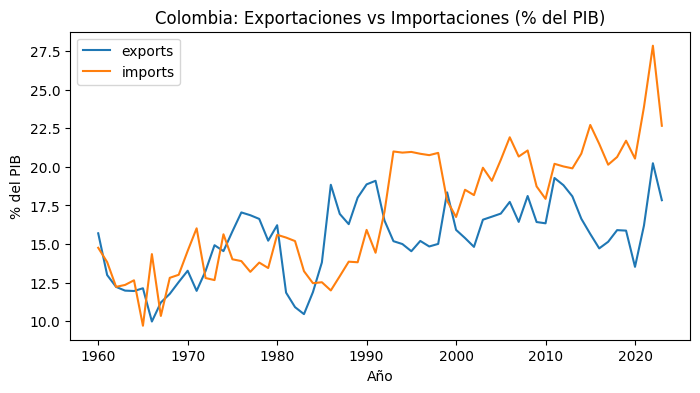

In [28]:
import matplotlib.pyplot as plt

ax = df.plot(x='year', y=['exports','imports'], figsize=(8,4), title='Colombia: Exportaciones vs Importaciones (% del PIB)')
ax.set_xlabel('Año')
ax.set_ylabel('% del PIB')
plt.show()
